# Histogram of Oriented Gradients `[HOG]`
Simplifies representation of images containing only crucial information [corners].

#### _Steps_:
1. Image Preprocessing
2. Buid Histogram
3. Extract Feature
4. Normalization
5. SVM Model
6. Sample showing `HOG` structure
7. Program Model on MNIST Dataset


> ## Depenedencies

In [2]:
import cv2
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

> ## Static & Input Section

In [3]:
BLOCK_SIZE = 16
BINS = 9    # Feature Vector of size [BINS]
STEPS = BLOCK_SIZE // 2
mnist_dataset = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist_dataset.load_data()

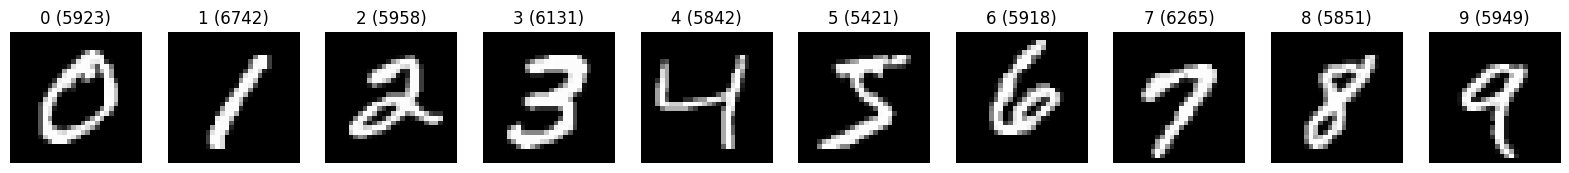

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
digit_counts = dict(zip(unique, counts))
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for digit in unique:
    index = np.where(y_train == digit)[0][0]
    axs[digit].imshow(X_train[index], cmap='gray')
    axs[digit].title.set_text(f'{digit} ({digit_counts[digit]})')
    axs[digit].axis('off')
plt.show()

In [5]:
def plot_me(IMAGE, color='grey', axis='on'):
    plt.imshow(IMAGE, cmap=color)
    plt.axis(axis)
    plt.show()
    

def create_map(BINS, START_INDEX, END_INDEX):
    return {temp:0 for temp in range(START_INDEX, END_INDEX+1, END_INDEX//BINS)}

# feature_vector = create_map(BINS=BINS, START_INDEX=0, END_INDEX=180)
feature_vectors = []

> ## STEP 1: Image Preprocessing

### 1. Normalize Image

In [6]:
def __imageNormalization__(IMAGE):
    if len(IMAGE.shape) > 2 and IMAGE.shape[2] > 1:
        IMAGE = cv2.cvtColor(IMAGE, cv2.COLOR_BGR2GRAY)
    return IMAGE / 255.0

### 2. Adjust Image Ratio

In [7]:
def __optimiseImageRatio__(IMAGE, printable=False):
    original_height, original_width = IMAGE.shape
    aspect_ratio_width, aspect_ratio_height = original_width, original_height
    if original_width > original_height and original_width % original_height != 0:
        aspect_ratio_width = (int(original_width / original_height) + 1) * original_height
    elif original_height > original_width and original_height % original_width != 0:
        aspect_ratio_height = (int(original_height / original_width) + 1) * original_width
    adjusted_image = cv2.resize(IMAGE, (aspect_ratio_width, aspect_ratio_height), interpolation=cv2.INTER_AREA)
    if printable == True:
        plt.figure(figsize=(3, 3))
        plt.imshow(adjusted_image, cmap='grey')
        plt.title(f'Adjusted Size: {adjusted_image.shape}')
        plt.show()
    return adjusted_image

### 3. Adjust BLOCKS of Image

In [8]:
def __divisibleBLOCKSIZE__(IMAGE, STEPS, printable=False):
    original_height, original_width = IMAGE.shape
    aspect_ratio_Bw, aspect_ratio_Bh = original_width, original_height
    if original_width % STEPS != 0:
        aspect_ratio_Bw = (int(original_width / STEPS) + 1) * STEPS
    if original_height % STEPS != 0:
        aspect_ratio_Bh = (int(original_height / STEPS) + 1) * STEPS
    padding = ((aspect_ratio_Bh - IMAGE.shape[0]) // 2,(aspect_ratio_Bw - IMAGE.shape[1]) // 2)
    padding_image = np.pad(IMAGE, pad_width=padding, mode='constant', constant_values=0)
    if printable == True:
        plt.figure(figsize=(3, 3))
        plt.imshow(padding_image, cmap='grey')
        plt.title(f'Padded Size: {padding_image.shape}')
        plt.show()
    return padding_image

> ## STEP 2: Build [HOG]

### 1. Calculate Histogram of Gradients

In [9]:
def __gradientImage__(IMAGE, printable=False):
    gx = cv2.Sobel(IMAGE, cv2.CV_64F, 1, 0, ksize=1)
    gy = cv2.Sobel(IMAGE, cv2.CV_64F, 0, 1, ksize=1)
    mag = np.sqrt(gx**2 + gy**2)
    angle = np.arctan2(gy, gx) * (180 / np.pi) % 180
    # mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    if printable == True:
        plt.figure(figsize=(18, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(gx, cmap='gray')
        plt.title('Gradient X')

        plt.subplot(1, 3, 2)
        plt.imshow(gy, cmap='gray')
        plt.title('Gradient Y')

        plt.subplot(1, 3, 3)
        plt.imshow(mag, cmap='gray')
        plt.title('Gradient Magnitude')

        plt.show()
    return mag, angle

### 2. Extract Image Blocks

In [10]:
def __cutImageBlocks__(IMAGE, BLOCK_SIZE=16, printable=False):
    subImages = []
    subMagnitudes = []
    subAngles = []
    # change iterations from increasing step -> 1
    # iterations_x = IMAGE.shape[0] // STEPS - 1
    # iterations_y = IMAGE.shape[1] // STEPS - 1

    iterations_x = IMAGE.shape[0]//2 +1
    iterations_y = IMAGE.shape[1]//2 +1
    
    row_start_index, row_end_index = 0, BLOCK_SIZE
    for row in range(0, iterations_x, STEPS):
        col_start_index, col_end_index = 0, BLOCK_SIZE
        for col in range(0, iterations_y, STEPS):
            sub_image = IMAGE[row_start_index:row_end_index, col_start_index:col_end_index]
            col_start_index += STEPS
            col_end_index += STEPS

            sub_mag, sub_ang = __gradientImage__(IMAGE=sub_image, printable=False)

            subImages.append(sub_image)
            subMagnitudes.append(sub_mag)
            subAngles.append(sub_ang)

            
        row_start_index += STEPS
        row_end_index += STEPS

    if printable == True:
        fig, axes = plt.subplots(1, len(subImages), figsize=(8,10))
        for i in range(0, len(subImages)):
            axes[i].imshow(subImages[i], cmap='inferno')
            axes[i].axis('off')
            axes[i].set_title(f'Sub-{i+1}')
        plt.tight_layout()
        plt.show()
    return subImages, subMagnitudes, subAngles

### 3. Apply Feature Descriptor

In [11]:
def __findInterval__(angle):
    if angle >= 0 and angle < 20:
        return 0
    if angle >= 20 and angle < 40:
        return 20
    if angle >= 40 and angle < 60:
        return 40
    if angle >= 60 and angle < 80:
        return 60
    if angle >= 80 and angle < 100:
        return 80
    if angle >= 100 and angle < 120:
        return 100
    if angle >= 120 and angle < 140:
        return 120
    if angle >= 140 and angle < 160:
        return 140
    if angle >= 160 and angle < 180:
        return 160
    
def __getFeatures__(cell_matrix, magnitude_matrix, angle_matrix, temp_feature_vector, STEP=20):
    for row_idx in range(len(angle_matrix)):
        for col_idx in range(len(angle_matrix[0])):
            current_interval_x = __findInterval__(angle_matrix[row_idx][col_idx])
            current_interval_y = current_interval_x + STEP
            current_interval_midpoint = (current_interval_x + current_interval_y) // 2

            next_interval_x = current_interval_y
            next_interval_y = next_interval_x + STEP
            next_interval_midpoint = (next_interval_x + next_interval_y) // 2

            PoF1 = abs(angle_matrix[row_idx][col_idx] - current_interval_midpoint) / STEP
            PoF2 = abs(angle_matrix[row_idx][col_idx] - next_interval_midpoint) / STEP

            VoP1 = PoF2 * magnitude_matrix[row_idx][col_idx]
            VoP2 = PoF1 * magnitude_matrix[row_idx][col_idx]

            if VoP1 > 1:
                VoP2 = magnitude_matrix[row_idx][col_idx]
                VoP1 = 0
            elif VoP2 > 1:
                VoP1 = magnitude_matrix[row_idx][col_idx]
                VoP2 = 0
            


            temp_feature_vector[current_interval_midpoint] += VoP2
            if next_interval_midpoint != 190:
                temp_feature_vector[next_interval_midpoint] += VoP1

    return temp_feature_vector
                

> ## STEP 3: HOG Feature Extractor

In [12]:
def __HOGDescriptor__(cells, magnitudes, angles, printable=False):
    image_feature_cells = []
    for i in range(0, len(cells)):
        temp = {  
            10 : 0,
            30 : 0,
            50 : 0,
            70 : 0,
            90 : 0,
            110: 0,
            130: 0,
            150: 0,
            170: 0
        }
        image_feature_cells.append(__getFeatures__(cells[i], magnitudes[i], angles[i], temp, 180//BINS))
    if printable == True:
        for x in range(0, len(image_feature_cells)):
            print(f"\tFeature_{x}", image_feature_cells[x])
    return image_feature_cells


> ## STEP 4: Normalize Feature Vectors

In [13]:
# def __HOGNormalization__(feature_block, printable=False):
#     normalized_block_feature = []
#     for feature in feature_block:
#         feature_value = np.array(list(feature.values()))
#         norm = np.linalg.norm(feature_value)
#         if norm == 0:
#             normalized_value = np.zeros_like(feature_value)
#         else:
#             normalized_value = feature_value / norm
#         norm_feature = {key: value for key, value in zip(feature.keys(), normalized_value)}
#         normalized_block_feature.append(norm_feature)   # 4x9
    
#     if printable == True:
#         for x in range(0, len(normalized_block_feature)):
#             print(f"\tN_Feature_{x}", normalized_block_feature[x])
#     return normalized_block_feature

def __HOGNormalization__(feature_block, printable=False):
    normalized_block_feature = []
    for feature_idx in range(0, len(feature_block)):
        total_sum = sum(feature_block[feature_idx].values())
        if total_sum != 0:
            normalized_block_feature.append([value / total_sum for value in feature_block[feature_idx].values()])
        else:
            normalized_block_feature.append([0] * len(feature_block[feature_idx]))
    if printable == True:
        for x in range(0, len(normalized_block_feature)):
            print(f"\tN_Feature_{x}", normalized_block_feature[x])
    return normalized_block_feature

## Sample Extraction

> ## STEP 5: Sample 

In [14]:
# Load Sample Image
sample = X_train[69]
sample.shape

(28, 28)

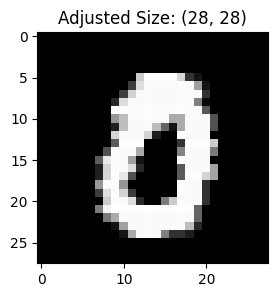

In [15]:
# Adjust Dimensions Ratio
adjust_sample = __optimiseImageRatio__(sample, True)

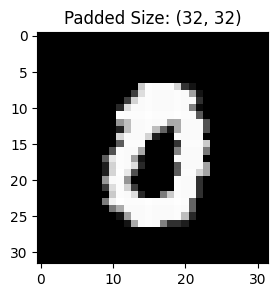

In [16]:
# Adjust Block Padding
pad_sample = __divisibleBLOCKSIZE__(adjust_sample, STEPS, True)

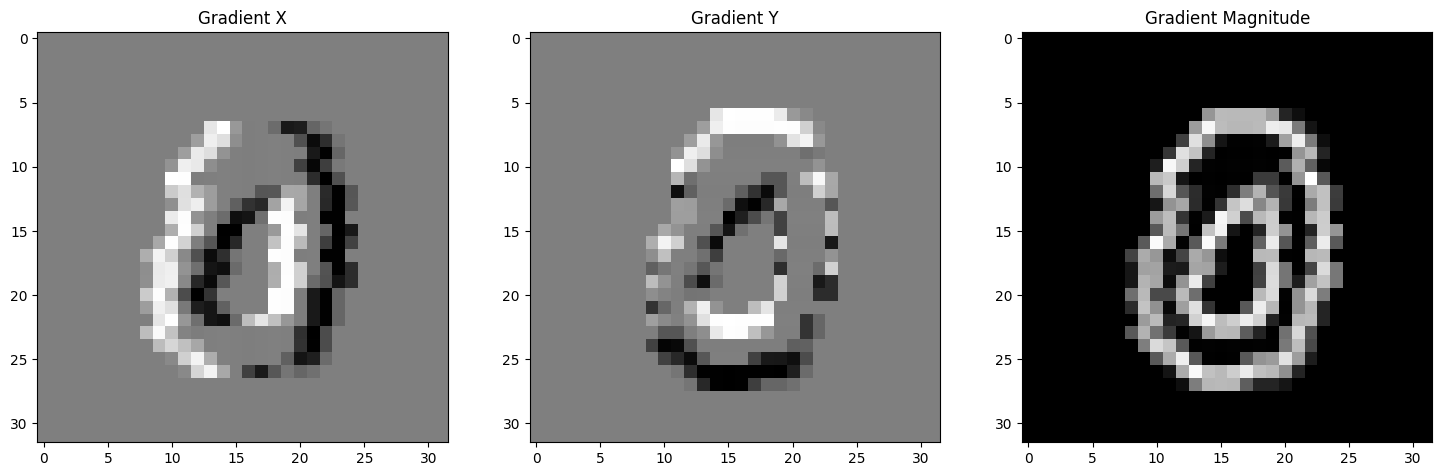

In [17]:
# Grediants
mag, ang = __gradientImage__(pad_sample, True)

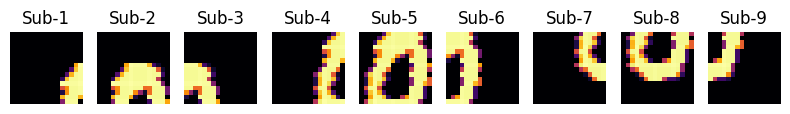

In [18]:
# Apply Sub-Blocks (16x16)
block, m, a = __cutImageBlocks__(pad_sample, BLOCK_SIZE=BLOCK_SIZE, printable=True)

In [19]:
# Apply 2nd Sub-Blocks (8x8) for each Block/Cell
Image = []
Magnitude = []
Angle = []
for sub_img_idx in range(0, len(block)):
    subBlock, magnitude, angle = __cutImageBlocks__(block[sub_img_idx], BLOCK_SIZE=BLOCK_SIZE//2, printable=False)
    Image.append(subBlock)
    Magnitude.append(magnitude)
    Angle.append(angle)

Image = np.array(Image)
Magnitude = np.array(Magnitude)
Angle = np.array(Angle)
(Image.shape, Magnitude.shape, Angle.shape)

((9, 4, 8, 8), (9, 4, 8, 8), (9, 4, 8, 8))

In [20]:
# Extract HoG Features
image_hog_feature = []
for sub_img_idx in range(0, len(Image)):
    print(f"BLOCK {sub_img_idx + 1}")
    cell_feature = __HOGDescriptor__(Image[sub_img_idx], Magnitude[sub_img_idx], Angle[sub_img_idx], True)
    print()
    image_hog_feature.append(cell_feature)

BLOCK 1
	Feature_0 {10: 0.0, 30: 0.0, 50: 0, 70: 0, 90: 0, 110: 0, 130: 0, 150: 0, 170: 0}
	Feature_1 {10: 457.0, 30: 0.0, 50: 0, 70: 0, 90: 457.0, 110: 0, 130: 0, 150: 0, 170: 0}
	Feature_2 {10: 0.0, 30: 0.0, 50: 0, 70: 0, 90: 0, 110: 0, 130: 0, 150: 0, 170: 0}
	Feature_3 {10: 2666.526740031575, 30: 399.113151461884, 50: 1314.9569096846335, 70: 0, 90: 329.0644491340181, 110: 0, 130: 295.79429544390723, 150: 117.13667231059623, 170: 98.08591926009544}

BLOCK 2
	Feature_0 {10: 457.0, 30: 0.0, 50: 0, 70: 0, 90: 457.0, 110: 0, 130: 0, 150: 0, 170: 0}
	Feature_1 {10: 504.0, 30: 0.0, 50: 0, 70: 0, 90: 1041.0, 110: 0, 130: 0, 150: 0, 170: 0}
	Feature_2 {10: 2666.526740031575, 30: 399.113151461884, 50: 1314.9569096846335, 70: 0, 90: 329.0644491340181, 110: 0, 130: 295.79429544390723, 150: 117.13667231059623, 170: 98.08591926009544}
	Feature_3 {10: 1988.5775074773385, 30: 0.0, 50: 304.5915792821957, 70: 521.4370461554659, 90: 1012.0246875958186, 110: 183.69812192834198, 130: 698.0890014769504,

In [21]:
# Apply Normalization
image_hog_normalization_features = []
for feature_img_idx in range(0, len(image_hog_feature)):
    print(f"Normalized BLOCK {feature_img_idx + 1}")
    cell_normalized_feature = __HOGNormalization__(image_hog_feature[feature_img_idx], True)
    print()
    image_hog_normalization_features.append(cell_feature)

Normalized BLOCK 1
	N_Feature_0 [0, 0, 0, 0, 0, 0, 0, 0, 0]
	N_Feature_1 [0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0]
	N_Feature_2 [0, 0, 0, 0, 0, 0, 0, 0, 0]
	N_Feature_3 [0.5107625235439225, 0.07644852660199677, 0.25187473257218795, 0.0, 0.06303097806035561, 0.0, 0.05665821329398618, 0.02243706070923901, 0.01878796521831187]

Normalized BLOCK 2
	N_Feature_0 [0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0]
	N_Feature_1 [0.3262135922330097, 0.0, 0.0, 0.0, 0.6737864077669903, 0.0, 0.0, 0.0, 0.0]
	N_Feature_2 [0.5107625235439225, 0.07644852660199677, 0.25187473257218795, 0.0, 0.06303097806035561, 0.0, 0.05665821329398618, 0.02243706070923901, 0.01878796521831187]
	N_Feature_3 [0.31719709349465114, 0.0, 0.0485852642343432, 0.08317418599930276, 0.16142759748774047, 0.029301603853507396, 0.11135185902307372, 0.07665120824628875, 0.17231118766109246]

Normalized BLOCK 3
	N_Feature_0 [0.3262135922330097, 0.0, 0.0, 0.0, 0.6737864077669903, 0.0, 0.0, 0.0, 0.0]
	N_Feature_1 [0, 0, 0, 0, 0, 0, 0, 0

## Comparing DL-SVM HOG with Built-in HOG

> ## STEP 6: Scratch HOG - Basel Youssef

### 0. Functions

In [23]:
def imageReshaper(X):
    """
    Adjust Image Ratio
    """
    X_reshape = []
    for i in range(0, len(X)):
        X_reshape.append(__optimiseImageRatio__(X[i], False))
    return np.array(X_reshape)


def imagePadder(X):
    """
    Add padding to work on block [16x16] - Not to Overflow
    """
    X_padd = []
    for i in range(0, len(X)):
        X_padd.append(__divisibleBLOCKSIZE__(X[i],STEPS=STEPS))
    return np.array(X_padd)


def imageSplitter(X):
    """
    Do multiple split
    1. First SubPlot: to get [9] Images each [16x16]
    2. Second SubPlot: to get [9] Images each [16x16] and subPlots them to [4] subImages each [8x8]
    """
    # 1st SubPlots
    X_1st = []
    for i in range(0, len(X)):
        B, M, A = __cutImageBlocks__(X[i], BLOCK_SIZE, False)
        X_1st.append(B)
    # 2nd SubPlots
    subImages, Megnitudes, Angles = [], [], []
    for image in X_1st:
        Cell, Meg, Ang = [], [], []
        for C in image:
            B, M, A = __cutImageBlocks__(C, BLOCK_SIZE//2, False)
            Cell.append(B)
            Meg.append(M)
            Ang.append(A)
        subImages.append(Cell)
        Megnitudes.append(Meg)
        Angles.append(Ang)
    return np.array(subImages), np.array(Megnitudes), np.array(Angles)


def imageHOG(Images, Megnitudes, Angles):
    """
    Feature Extraction [i]:Images | [j]:Blocks | [k]:Cells
    """
    DATA_FEATURE = []
    for img_idx in range(0, len(Images)):                               # 70K-iteration [i]:Images
        BLOCK_FEATURE = []
        for block_idx in range(0, len(Images[img_idx])):                # 9-iterations  [j]:Blocks
            block_feature = __HOGDescriptor__(Images[img_idx][block_idx], Megnitudes[img_idx][block_idx], Angles[img_idx][block_idx], False)
            BLOCK_FEATURE.append(block_feature)
        DATA_FEATURE.append(BLOCK_FEATURE)
    return np.array(DATA_FEATURE)


def imageNormalizor(Features):
    """
    Normalize Feature Vector [0:1]
    """
    DATA_NORM_FEATURE = []
    for ftr_idx in range(0, len(Features)):
        BLOCK_NORM_FEATURE = []
        for block_idx in range(0, len(Features[ftr_idx])):
            data_norm_feature = __HOGNormalization__(Features[ftr_idx][block_idx], False)
            BLOCK_NORM_FEATURE.append(data_norm_feature)
        DATA_NORM_FEATURE.append(BLOCK_NORM_FEATURE)
    return np.array(DATA_NORM_FEATURE)


In [24]:
# Combine into one Data
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
print(X.shape, y.shape)
X, _, y, _ = train_test_split(X, y, test_size=0.5, random_state=42)
print(X.shape, y.shape)

(70000, 28, 28) (70000,)
(35000, 28, 28) (35000,)


In [25]:
data_ratio = imageReshaper(X)
data_reshape_32x32 = imagePadder(data_ratio)
data_images, data_megnitudes, data_angles = imageSplitter(data_reshape_32x32)
data_features = imageHOG(data_images, data_megnitudes, data_angles)
data_norm_features = imageNormalizor(data_features)

In [26]:
X_Features = data_norm_features.reshape(len(data_norm_features), -1)
X_Features.shape

(35000, 324)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_Features, y, test_size=0.2, random_state=42)

svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, y_train)

train_accuracy = svm_model.score(X_train, y_train)
test_accuracy = svm_model.score(X_test, y_test)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

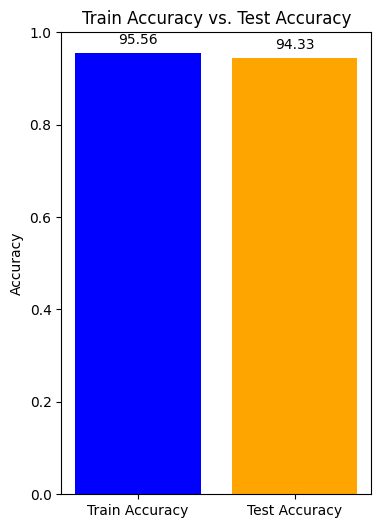

In [31]:
plt.figure(figsize=(4, 6))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Test Accuracy')
for i, v in enumerate([train_accuracy, test_accuracy]):
    plt.text(i, v + 0.02, f"{v * 100:.2f}", ha='center')
plt.show()

> ## STEP 7: Built-in HOG

In [32]:
from skimage.feature import hog
from sklearn import datasets, svm, metrics

In [33]:
X_built_train, X_built_test, y_built_train, y_built_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_built_train = X_built_train.reshape(-1, 28*28).astype(np.float32) / 255.0
X_built_test = X_built_test.reshape(-1, 28*28).astype(np.float32) / 255.0

hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (3, 3),
    'block_norm': 'L2-Hys',
    'transform_sqrt': True,
    'feature_vector': True
}

def extract_hog_features(data):
    hog_features = []
    for image in data:
        hog_feature = hog(image.reshape(28, 28), **hog_params)
        hog_features.append(hog_feature)
    return np.array(hog_features)

x_train_hog = extract_hog_features(X_built_train)
x_test_hog = extract_hog_features(X_built_test)

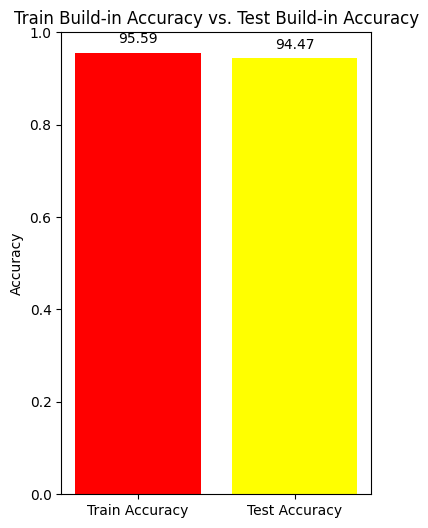

In [35]:
svm_built_model = svm.SVC(kernel='linear')
svm_built_model.fit(x_train_hog, y_train)

y_train_pred = svm_built_model.predict(x_train_hog)
y_test_pred = svm_built_model.predict(x_test_hog)

train_build_accuracy = accuracy_score(y_train, y_train_pred)
test_build_accuracy = accuracy_score(y_test, y_test_pred)

plt.figure(figsize=(4, 6))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['red', 'yellow'])
plt.ylim(0, 1)  # Set y-axis limit to range [0, 1]
plt.ylabel('Accuracy')
plt.title('Train Build-in Accuracy vs. Test Build-in Accuracy')
for i, v in enumerate([train_build_accuracy, test_build_accuracy]):
    plt.text(i, v + 0.02, f"{v * 100:.2f}", ha='center')
plt.show()